In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd


In [20]:
pys = list(Doc.objects.filter(pk__in=df.sort_values('id').id).order_by('pk').values_list('PY',flat=True))
pys[:5]

[2007, 2007, 2015, 2013, 2012]

In [29]:
pydf = df.sort_values('id')
pydf['PY'] = pys
df = pydf.sort_index()
df.to_csv('../data/category_predictions.csv',index=False)
#df[['id','content','PY']].head()

In [28]:
df = pd.read_csv('../data/category_predictions.csv')


pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]

for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
print(pred_cats)

attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
attrib_cats


df.head()

1994.0
2135.833333333333
7694.166666666668
7977.833333333335
3508.5
3682.3333333333335
28089.166666666668
28527.000000000004
6168.333333333334
6409.000000000001
['12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Coastal and marine Ecosystems - mean_prediction', '12 - Terrestrial ES - mean_prediction', '12 - Human and managed - mean_prediction']
37018.0
37444.333333333336
26211.0
26536.166666666664
1869.0000000000002
1975.0000000000002


,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,2 - Trend or climate change attribtion - upper_pred,2 - 2.4. Sensitivity - mean_prediction,2 - 2.4. Sensitivity - std_prediction,2 - 2.4. Sensitivity - lower_pred,2 - 2.4. Sensitivity - upper_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - mean_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - std_prediction,2 - 2.5. Detection of a regional climate trend (no attribution) - lower_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - upper_pred,PY
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.539345,1.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,2014.0
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,1.000000,0.833333,0.372678,0.460655,1.000000,0.0,0.0,0.0,0.0,2018.0
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,1.000000,0.166667,0.372678,0.000000,0.539345,0.0,0.0,0.0,0.0,2001.0
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2012.0
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,0.804738,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2015.0


In [29]:
geos = pd.read_csv('../data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","geonameid"])
print(geos.shape)
geos.head()

(105576, 9)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,NaN,39.76000,-98.5000,USA,6252001,United States,A,PCLI,3305893
1,NaN,22.00000,79.0000,IND,1269750,Republic of India,A,PCLI,1477550
2,NaN,60.00000,100.0000,RUS,2017370,Russian Federation,A,PCLI,1477550
3,Punjab,31.47060,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,SCHC,1477550
4,NaN,3.51342,-132.1875,NaN,2363254,Pacific Ocean,H,OCN,1477550


In [30]:
places = pd.read_csv('../data/place_df.csv')
places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893
1,1,Northern Pakistan,"[{'start': 52, 'end': 69}]",PAK,0.000000,NaN,1477550
2,2,Western RussiaPakistan,"[{'start': 100, 'end': 122}]",RUS,0.000000,NaN,1477550
3,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550
4,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550


In [31]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,2 - 2.5. Detection of a regional climate trend (no attribution) - lower_pred,2 - 2.5. Detection of a regional climate trend (no attribution) - upper_pred,PY,Unnamed: 0_y,word,spans,country_predicted,country_conf,geo,doc_id
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.0,0.0,2014.0,86174,China,"[{'start': 157, 'end': 162}]",CHN,0.999764,"{'admin1': 'NA', 'lat': '35', 'lon': '105', 'c...",136746
1,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.0,0.0,2014.0,86175,Qinghai,"[{'start': 1777, 'end': 1784}]",CHN,0.993103,"{'admin1': 'Qinghai', 'lat': '36', 'lon': '96'...",136746
2,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.0,0.0,2014.0,86176,Inner Mongolia,"[{'start': 1786, 'end': 1800}]",CHN,0.993103,"{'admin1': 'Inner Mongolia', 'lat': '43.5', 'l...",136746
3,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.0,0.0,2014.0,86177,Xinjiang,"[{'start': 1806, 'end': 1814}]",CHN,0.993103,{'admin1': 'Xinjiang Uyghur Autonomous Region'...,136746
4,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,0.0,0.0,2014.0,86178,Gansu,"[{'start': 1922, 'end': 1927}]",CHN,0.993103,"{'admin1': 'Gansu', 'lat': '37.75', 'lon': '10...",136746


In [32]:
import pycountry_convert as pc
def get_cont(x):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))
    except:
        return None
df_places['continent'] = df_places.apply(lambda x: get_cont(x), axis=1)


In [33]:
df_places['continent']

0         AS
1         AS
2         AS
3         AS
4         AS
          ..
286350    EU
286351    EU
286352    EU
286353    EU
286354    OC
Name: continent, Length: 286355, dtype: object

In [34]:

pdf = (df_places.groupby(['PY','continent'])['id']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"id":"N studies"})
      )
pdf.head()

,PY,continent,N studies
19,1991.0,AF,112
20,1991.0,AS,89
21,1991.0,EU,127
22,1991.0,NA,285
23,1991.0,OC,45


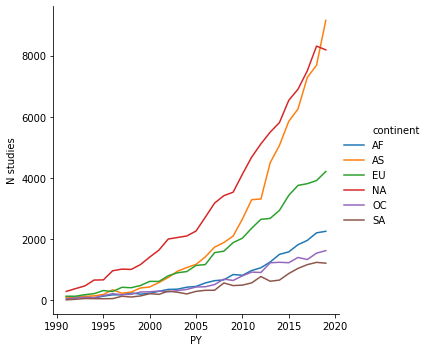

In [35]:
import seaborn as sns
sns.relplot("PY","N studies",hue="continent",data=pdf,kind="line")
plt.savefig('../plots/literature_distribution/PY_continent_n.pdf')

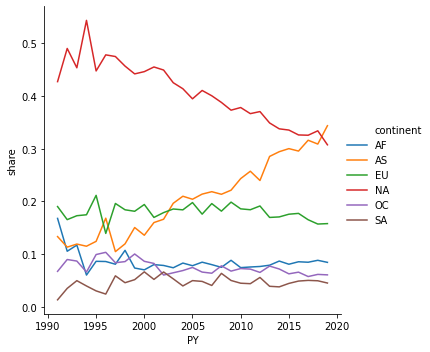

In [36]:
pdf['share'] = pdf['N studies'] / pdf.groupby('PY')['N studies'].transform('sum')

sns.relplot("PY","share",hue="continent",data=pdf,kind="line")
plt.savefig('../plots/literature_distribution/PY_continent_shares.pdf')

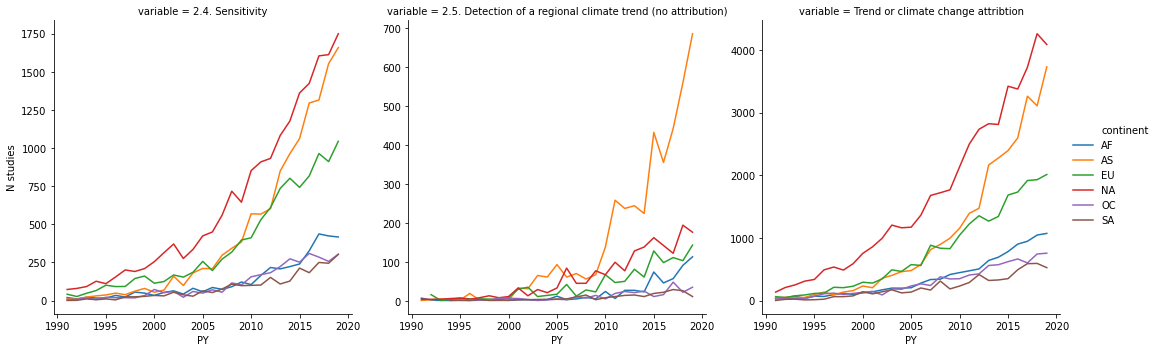

In [83]:
pdf = (df_places[['id','continent','PY']+attrib_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="continent",data=pdf,col="variable",kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_attrib.pdf")

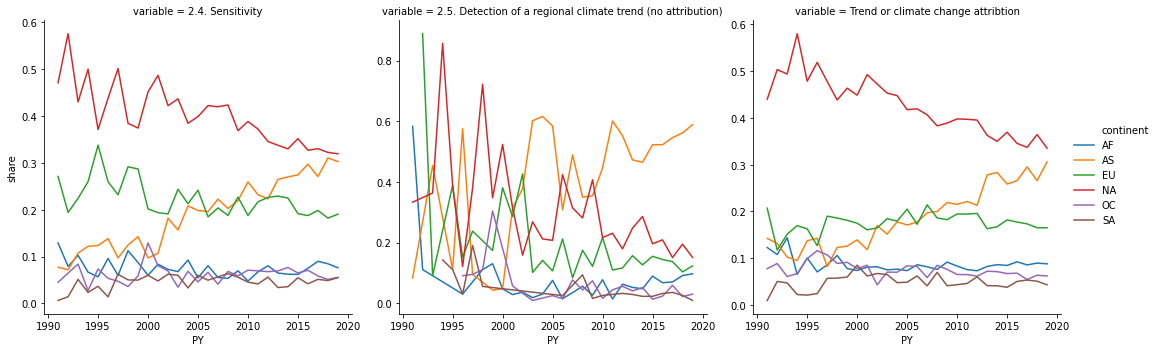

In [79]:
pdf['share'] = pdf['N studies'] / pdf.groupby(['PY','variable'])['N studies'].transform('sum')
sns.relplot("PY","share",hue="continent",data=pdf,col="variable",kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_attrib_share.pdf")

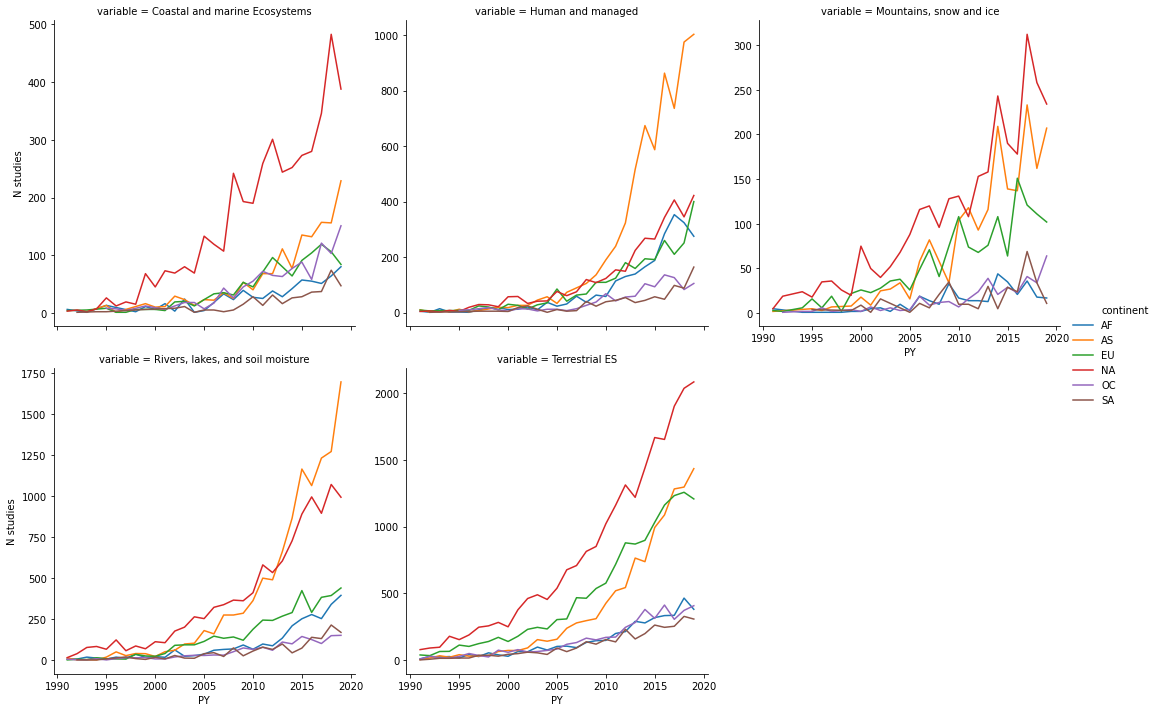

In [82]:
pdf = (df_places[['id','continent','PY']+pred_cats]
       .melt(id_vars=["id","continent","PY"])
       .query('value>0.5')
       .groupby(['PY','continent','variable'])['value']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"value":"N studies"})
      )
pdf["variable"] = pdf["variable"].str.split(' - ').str[1]
pdf.head()
sns.relplot("PY","N studies",hue="continent",data=pdf,col="variable", col_wrap=3,kind="line",facet_kws={'sharey': False, 'sharex': True})
plt.savefig("../plots/literature_distribution/PY_continent_impact.pdf")